
## Part B: Attention Contextualization

### Objective
Static word embeddings assign a single vector to a token regardless of context, which fails to capture polysemy.
This notebook demonstrates how self-attention produces context-dependent representations by mathematically
computing attention over simple 2D embeddings.

We show that the same word embedding can shift meaning depending on surrounding tokens.


## Homonym Selection and Sentences

To demonstrate contextualization, we select the homonym **"bat"**, which has multiple meanings
depending on context.

**Sentence 1 (sports context):**  
He swung the bat and hit the ball.

**Sentence 2 (animal context):**  
A bat was flying in the dark cave.


## Tokenization

For simplicity, each sentence is tokenized manually into individual tokens.

**Sentence 1 tokens:**
\
["he", "swung", "the", "bat", "ball"]


**Sentence 2 tokens:**
\
["a", "bat", "was", "flying", "cave"]


The token **"bat"** appears in both sentences with the same initial embedding.
Any difference in its final representation will therefore be caused purely by context.


- Static embeddings assign one vector per token.
- RNNs process tokens sequentially, which limits access to distant context.
- LSTMs mitigate vanishing gradients but still encode context into a single hidden state.

Self-attention removes this bottleneck by allowing each token to directly attend
to all other tokens in the sequence. In this part, we implement a simplified
self-attention mechanism to observe this effect explicitly.


## Embedding Initialization

We initialize simple 2D embeddings for each token.
All embeddings are static and manually defined.

The token **"bat"** is assigned the same initial embedding in both sentences.
Any difference in its final representation will therefore be caused by self-attention.


In [1]:
import numpy as np

In [2]:

# 2D embeddings for Sentence 1 tokens
embeddings_s1 = {
    "he":     np.array([0.1, 0.0]),
    "swung":  np.array([0.0, 0.2]),
    "the":    np.array([0.1, 0.1]),
    "bat":    np.array([0.2, 0.1]),  # same embedding in both sentences
    "ball":   np.array([0.0, 0.3])
}

# 2D embeddings for Sentence 2 tokens
embeddings_s2 = {
    "a":      np.array([0.1, 0.0]),
    "bat":    np.array([0.2, 0.1]),  # same embedding
    "was":    np.array([0.0, 0.1]),
    "flying": np.array([0.3, 0.2]),
    "cave":   np.array([0.1, 0.3])
}


## Embedding Matrix Construction

For each sentence, embeddings are stacked into a matrix **E**.
Each row corresponds to a token embedding in the order of the sentence.
This matrix is used directly as queries, keys, and values (Q = K = V = E).


In [3]:
# Token order (must match the sentences)
tokens_s1 = ["he", "swung", "the", "bat", "ball"]
tokens_s2 = ["a", "bat", "was", "flying", "cave"]

# Build embedding matrices
E1 = np.stack([embeddings_s1[token] for token in tokens_s1])
E2 = np.stack([embeddings_s2[token] for token in tokens_s2])

E1, E2


(array([[0.1, 0. ],
        [0. , 0.2],
        [0.1, 0.1],
        [0.2, 0.1],
        [0. , 0.3]]),
 array([[0.1, 0. ],
        [0.2, 0.1],
        [0. , 0.1],
        [0.3, 0.2],
        [0.1, 0.3]]))

## Attention Score Computation

Self-attention computes similarity between all token pairs using the dot product.
Since Q = K = E, the attention score matrix is computed as:

$$QK^\top = EE^\top$$

Each entry represents how strongly one token attends to another.

---

### Mathematical Explanation

| Component | Description |
|-----------|-------------|
| **E** | Embedding matrix (tokens × embedding_dim) |
| **Q** | Query matrix = E |
| **K** | Key matrix = E |
| **QKᵀ** | Attention scores (tokens × tokens) |

---

### Step-by-Step Calculation

Given embeddings E with shape (n_tokens, d_model):

$$E = \begin{bmatrix}
e_1 \\
e_2 \\
\vdots \\
e_n
\end{bmatrix}$$

Where each $e_i$ is a row vector representing token i's embedding.

The attention score matrix is:

$$QK^\top = EE^\top = \begin{bmatrix}
e_1 \cdot e_1 & e_1 \cdot e_2 & \cdots & e_1 \cdot e_n \\
e_2 \cdot e_1 & e_2 \cdot e_2 & \cdots & e_2 \cdot e_n \\
\vdots & \vdots & \ddots & \vdots \\
e_n \cdot e_1 & e_n \cdot e_2 & \cdots & e_n \cdot e_n
\end{bmatrix}$$

Each entry $(i,j)$ represents:

$$\text{score}_{ij} = e_i \cdot e_j = \sum_{k=1}^{d} e_{i,k} \cdot e_{j,k}$$

---

### Interpretation

| Score Value | Meaning |
|-------------|---------|
| High positive | Tokens are similar/related |
| Near zero | Tokens are unrelated |
| Negative | Tokens are dissimilar |

---

### Example with 2D Embeddings

Suppose we have 3 tokens with 2D embeddings:

$$E = \begin{bmatrix}
1 & 0 \\
0.5 & 0.5 \\
0 & 1
\end{bmatrix}$$

Then:

$$EE^\top = \begin{bmatrix}
1 & 0 \\
0.5 & 0.5 \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
1 & 0.5 & 0 \\
0 & 0.5 & 1
\end{bmatrix}
= \begin{bmatrix}
1 & 0.5 & 0 \\
0.5 & 0.5 & 0.5 \\
0 & 0.5 & 1
\end{bmatrix}$$

| Score | Interpretation |
|-------|----------------|
| (1,1) = 1 | Token 1 attends fully to itself |
| (1,2) = 0.5 | Token 1 moderately attends to token 2 |
| (1,3) = 0 | Token 1 doesn't attend to token 3 |

---

### Next Step: Apply Softmax

After computing $QK^\top$, we apply softmax to normalize scores into attention weights:

$$A = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)$$

Where $d_k$ is the embedding dimension (scaling factor for stability).

In [4]:
# Compute raw attention scores
scores_s1 = E1 @ E1.T
scores_s2 = E2 @ E2.T

scores_s1, scores_s2


(array([[0.01, 0.  , 0.01, 0.02, 0.  ],
        [0.  , 0.04, 0.02, 0.02, 0.06],
        [0.01, 0.02, 0.02, 0.03, 0.03],
        [0.02, 0.02, 0.03, 0.05, 0.03],
        [0.  , 0.06, 0.03, 0.03, 0.09]]),
 array([[0.01, 0.02, 0.  , 0.03, 0.01],
        [0.02, 0.05, 0.01, 0.08, 0.05],
        [0.  , 0.01, 0.01, 0.02, 0.03],
        [0.03, 0.08, 0.02, 0.13, 0.09],
        [0.01, 0.05, 0.03, 0.09, 0.1 ]]))

## Attention Weights

The raw attention scores are normalized using the softmax function.
Softmax is applied row-wise so that attention weights for each token
sum to 1.


In [5]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Apply softmax to attention scores
A1 = softmax(scores_s1)
A2 = softmax(scores_s2)

A1, A2


(array([[0.20039478, 0.19840082, 0.20039478, 0.20240879, 0.19840082],
        [0.19443715, 0.20237228, 0.19836504, 0.19836504, 0.20646048],
        [0.19760881, 0.19959482, 0.19959482, 0.20160078, 0.20160078],
        [0.19799805, 0.19799805, 0.19998796, 0.20402799, 0.19998796],
        [0.19168399, 0.20353706, 0.19752163, 0.19752163, 0.20973569]]),
 array([[0.19919123, 0.20119314, 0.19720924, 0.20321516, 0.19919123],
        [0.19558772, 0.20154425, 0.19364159, 0.20768219, 0.20154425],
        [0.19720924, 0.19919123, 0.19919123, 0.20119314, 0.20321516],
        [0.19200018, 0.20184424, 0.19008975, 0.21219302, 0.20387281],
        [0.19089531, 0.19868589, 0.19475165, 0.20679442, 0.20887274]]))

## Contextualized Representations

The contextualized token representations are computed as:

$$Z = A \cdot V$$

Since V = E, each output vector is a weighted sum of all token embeddings,
where the weights are given by the attention matrix.


In [6]:
# Compute contextualized representations
Z1 = A1 @ E1
Z2 = A2 @ E2

Z1, Z2


(array([[0.08056071, 0.13948077],
        [0.07895323, 0.14208561],
        [0.08004052, 0.14051876],
        [0.0806042 , 0.13999759],
        [0.07842489, 0.14313245]]),
 array([[0.14104142, 0.14024064],
        [0.1423267 , 0.1415183 ],
        [0.14023863, 0.14104142],
        [0.14361405, 0.14279385],
        [0.14175231, 0.14336446]]))

## Validation of Contextual Shift

To verify that self-attention produces different representations for the same token
depending on context, we compare the final contextualized embeddings of the token
**"bat"** in both sentences.

Cosine similarity is used to measure how similar the two vectors are.


In [7]:
# Helper function: cosine similarity
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Index of "bat" in each sentence
bat_index_s1 = tokens_s1.index("bat")
bat_index_s2 = tokens_s2.index("bat")

# Extract contextualized embeddings of "bat"
bat_vec_s1 = Z1[bat_index_s1]
bat_vec_s2 = Z2[bat_index_s2]

bat_vec_s1, bat_vec_s2


(array([0.0806042 , 0.13999759]), array([0.1423267, 0.1415183]))

In [8]:
similarity = cosine_similarity(bat_vec_s1, bat_vec_s2)
similarity


np.float64(0.9648707545783209)

## Interpreting Attention for the Token "bat"

To understand how attention captures context, we inspect the attention
distribution of the token **"bat"** over all other tokens in each sentence.

This directly shows which surrounding words influence the meaning of "bat".


In [11]:
import pandas as pd

# Attention row corresponding to "bat"
bat_attention_s1 = A1[bat_index_s1]
bat_attention_s2 = A2[bat_index_s2]

# Create tables
df_s1 = pd.DataFrame({
    "Token": tokens_s1,
    "Attention Weight": bat_attention_s1
}).sort_values(by="Attention Weight", ascending=False)

df_s2 = pd.DataFrame({
    "Token": tokens_s2,
    "Attention Weight": bat_attention_s2
}).sort_values(by="Attention Weight", ascending=False)

df_s1, df_s2


(   Token  Attention Weight
 3    bat          0.204028
 4   ball          0.199988
 2    the          0.199988
 0     he          0.197998
 1  swung          0.197998,
     Token  Attention Weight
 3  flying          0.207682
 4    cave          0.201544
 1     bat          0.201544
 0       a          0.195588
 2     was          0.193642)

## Visualization: Contextualized Representations of "bat"

The following plot shows the contextualized embeddings of the token "bat"
in both sentences, illustrating how attention shifts its representation.


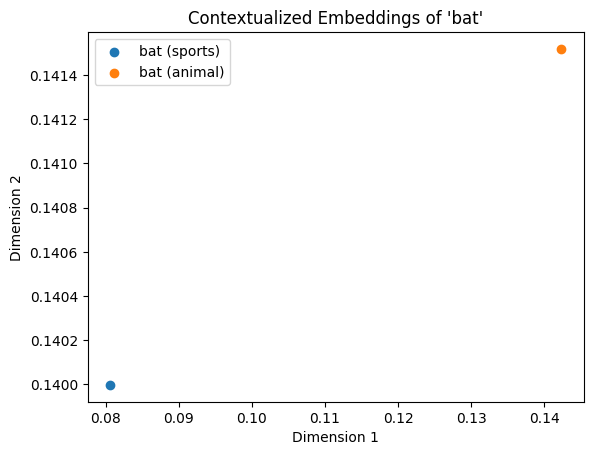

In [10]:
plt.figure()
plt.scatter(bat_vec_s1[0], bat_vec_s1[1], label="bat (sports)")
plt.scatter(bat_vec_s2[0], bat_vec_s2[1], label="bat (animal)")
plt.legend()
plt.title("Contextualized Embeddings of 'bat'")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


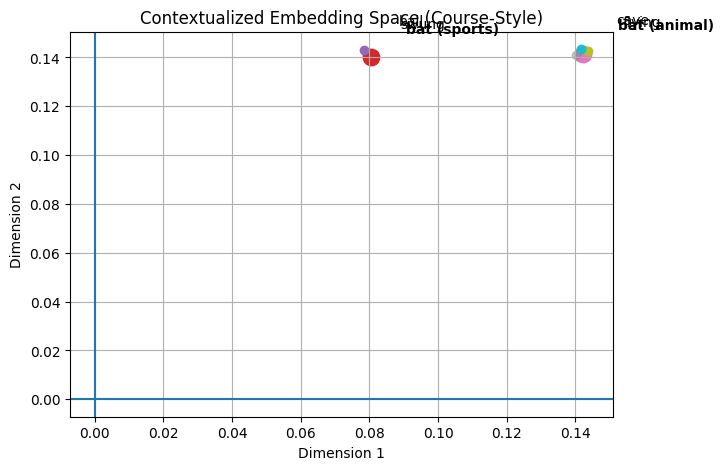

In [14]:
plt.figure(figsize=(7, 5))

# Sentence 1 (sports context)
for i, token in enumerate(tokens_s1):
    x, y = Z1[i]
    if token == "bat":
        plt.scatter(x, y, s=140)
        plt.text(x+0.01, y+0.01, "bat (sports)", fontweight="bold")
    elif token in ["ball", "swung"]:
        plt.scatter(x, y)
        plt.text(x+0.01, y+0.01, token)
    else:
        plt.scatter(x, y, alpha=0.4)

# Sentence 2 (animal context)
for i, token in enumerate(tokens_s2):
    x, y = Z2[i]
    if token == "bat":
        plt.scatter(x, y, s=140)
        plt.text(x+0.01, y+0.01, "bat (animal)", fontweight="bold")
    elif token in ["flying", "cave"]:
        plt.scatter(x, y)
        plt.text(x+0.01, y+0.01, token)
    else:
        plt.scatter(x, y, alpha=0.4)

plt.axhline(0)
plt.axvline(0)
plt.title("Contextualized Embedding Space (Course-Style)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


## Conclusion

Although the token **"bat"** was initialized with the same static embedding in both
sentences, self-attention produced different contextualized representations.

This confirms that attention enables context-sensitive meaning by allowing each token
to attend to surrounding tokens, addressing the limitations of static embeddings.
